In [289]:
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
import numpy as np
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score

In [290]:
current_sequence = "CLClim3NE1"
CLNE_sequence = "CLNE_11192024"

In [291]:
# read in the unfiltered data: 
CLClimNE_log_data_with_proteases = pd.read_csv('out/CLClim3NE1/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')

# remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_data_with_proteases['Monomer ID'] = CLClimNE_log_data_with_proteases['Monomer ID'].str[:-3]
CLClimNE_log_data_with_proteases

,Monomer ID,Log10 Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,2.239675
1,1-PFK-MONOMER,1.747600
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,2.321794
3,2-ISOPROPYLMALATESYN-MONOMER,3.482980
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,2.695617
...,...,...
4305,YTFR-MONOMER,1.180822
4306,YTFT-MONOMER,1.138950
4307,ZNUA-MONOMER,2.872238
4308,ZNUB-MONOMER,1.829640


add the gene names and the protease assignments

In [292]:
# add the gene names: 
common_names = "reconstruction/ecoli/scripts/protein_half_lives/Gupta_et_al_Clim_data/Clim_EcoCyc_monomer_ID_matches/41467_2024_49920_MOESM4_ESM_ST1_EcoCyc_monomer_ID_matches_11202024.tsv"
common_names = pd.read_csv(common_names, sep='\t', skiprows=1)
# read in the priority protease data: 
priority_substrates = "models/ecoli/analysis/local_notebooks/protease_substrate_relationships/data/priority_protease_assignments_0.tsv"
priority_substrates = pd.read_csv(priority_substrates, sep='\t', skiprows=1)
# add the CLim3 HL source: 
CLClim3NE1_HLs = "out/CLClim3NE1/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')

# add the protease assginment
CLClimNE_log_data_with_proteases['protease assignment'] = "NA"
for index, row in CLClimNE_log_data_with_proteases.iterrows():
    if row['Monomer ID'] in priority_substrates['id'].values:
        CLClimNE_log_data_with_proteases.at[index, 'protease assignment'] = priority_substrates[priority_substrates['id'] == row['Monomer ID']]['protease_assignment'].values[0]
   
# add the gene symbol
CLClimNE_log_data_with_proteases['gene symbol'] = None
for index, row in CLClimNE_log_data_with_proteases.iterrows():
    if row['Monomer ID'] in common_names['Monomer ID'].values:
        CLClimNE_log_data_with_proteases.at[index, 'gene symbol'] = common_names[common_names['Monomer ID'] == row['Monomer ID']]['Common Name'].values[0]
        
# add in the HL source: 
CLClimNE_log_data_with_proteases['HL source'] = None
CLClimNE_log_data_with_proteases['HL value'] = None
for index, row in CLClimNE_log_data_with_proteases.iterrows():
    if row['Monomer ID'] in CLClim3NE1_HLs['monomer_id'].values:
        CLClimNE_log_data_with_proteases.at[index, 'HL source'] = CLClim3NE1_HLs[CLClim3NE1_HLs['monomer_id'] == row['Monomer ID']]['degradation_rate_source'].values[0]
        CLClimNE_log_data_with_proteases.at[index, 'HL value'] = CLClim3NE1_HLs[CLClim3NE1_HLs['monomer_id'] == row['Monomer ID']]['half_life_(min)'].values[0]
        
   
# add the half life source in the Clim3 data: 
# todo actually there is only so much that can be in the hover data, see if this can be added too 

CLClimNE_log_data_with_proteases

,Monomer ID,Log10 Average Monomer Counts,protease assignment,gene symbol,HL source,HL value
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,2.239675,NA,plsC,Gupta_et_al_MS_2024,501.707893
1,1-PFK-MONOMER,1.747600,NA,fruK,Gupta_et_al_MS_2024,766.256894
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,2.321794,NA,panE,N_end_rule,600.0
3,2-ISOPROPYLMALATESYN-MONOMER,3.482980,NA,leuA,Gupta_et_al_MS_2024,276.924332
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,2.695617,NA,ubiE,Gupta_et_al_MS_2024,493.39705
...,...,...,...,...,...,...
4305,YTFR-MONOMER,1.180822,NA,ytfR,Gupta_et_al_MS_2024,654.149344
4306,YTFT-MONOMER,1.138950,NA,ytfT,N_end_rule,600.0
4307,ZNUA-MONOMER,2.872238,NA,znuA,Gupta_et_al_MS_2024,638.129701
4308,ZNUB-MONOMER,1.829640,NA,None,N_end_rule,600.0


In [293]:
# figure out which proteins were assigned to lon in the model: 
lon_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Lon only']
lon_proteins

# figure out which proteins were assigned to clp in the model:
clp_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'ClpP only']

hslv_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'HslV only']

# figure out which proteins are additive in the model: 
additive_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Additive: ClpP, Lon']

# figure out which proteins are redundant in the model: 
redundant_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Additive: ClpP, Lon, HslV']



# figure out which proteins were not assigned to a protease in the model:
no_protease_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'NA']

# todo: note that these numbers will not add up to those in the graph below bc some proteins in the CLClim0NE model are not in the CLNE model 
#298 total 
print("Lon Proteins(" +str(len(lon_proteins))+"): ", list(lon_proteins['gene symbol'])) #14
print("ClpP Proteins(" +str(len(clp_proteins))+"): ", list(clp_proteins['gene symbol'])) #63
print("HslV Proteins(" +str(len(hslv_proteins))+"): ", list(hslv_proteins['gene symbol'])) #1
print("Additive Proteins: Lon, ClpP (" +str(len(additive_proteins))+"): ", list(additive_proteins['gene symbol'])) #79
print("Additive: Lon, ClpP, HslV Proteins(" +str(len(redundant_proteins))+"): ", list(redundant_proteins['gene symbol'])) #39
#print("No Protease Proteins(" +str(len(no_protease_proteins))+"): ", list(no_protease_proteins['gene symbol'])) # 4012

# ClpP does not have 

Lon Proteins(6):  ['ydcI', 'nemA', 'fhlA', 'metR', 'trxC', 'rpoD']
ClpP Proteins(40):  ['fadE', 'glpD', 'cysD', 'ribB', 'clpA', 'clpX', 'dksA', 'dnaB', 'dnaK', 'ftsZ', 'mukB', 'mutS', 'nfo', 'parC', 'pcnB', 'recA', 'rpsA', 'sbcC', 'uvrD', 'dps', 'def', 'phoH', 'intA', 'rutA', 'comR', 'ydhQ', 'yfcZ', 'patA', 'obgE', 'yheO', 'lldD', 'mdlB', 'oxyR', 'exuR', 'putA', 'rpoB', 'rpoC', 'rpoS', 'yheS', 'znuC']
HslV Proteins(1):  ['uhpA']
Additive Proteins: Lon, ClpP (3):  ['ibpA', 'grcA', 'dnaA']
Additive: Lon, ClpP, HslV Proteins(32):  ['aroK', 'helD', 'ligA', 'minE', 'parE', 'pspA', 'rhlB', 'srmB', 'ybaB', 'yibA', 'mazF', 'yjgA', 'yihD', 'yiiQ', 'yiaU', 'yfhH', 'erpA', 'ppiC', 'glaR', 'chaB', 'rarA', 'proQ', 'acpP', 'ycaR', 'hprR', 'murQ', 'iscR', 'kbp', 'yggX', 'glnD', 'yaeP', 'thiL']


In [294]:
# prepare the data for a plot:
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.copy()

CLNE_log_data = pd.read_csv('/Users/miagrahn/wcEcoli/out/CLNE_11192024/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# merge the two dataframes:
CLNE_new_name = "Log10 " +CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"

CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
#CLNE_log_data = CLNE_log_data[["Monomer ID", "Log10 CLNE Protein Counts"]]
#CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases[["Monomer ID", "Log10 CLClim0NE Protein Counts"]]
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.set_index("Monomer ID")
CLNE_CLClimNE_log_data_proteases = CLNE_log_data.join(CLClimNE_log_data_with_proteases, how="inner")
CLNE_CLClimNE_log_data_proteases = CLNE_CLClimNE_log_data_proteases.reset_index()

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_Lon_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Clp_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_HslV_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LC = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LCH = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_no_protease_proteases = CLNE_CLClimNE_log_data_proteases.copy()

# remove the proteins that were not assigned to the protease in the model:
CLClimNE_log_data_with_Lon_proteases = CLClimNE_log_data_with_Lon_proteases[CLClimNE_log_data_with_Lon_proteases['protease assignment'] == 'Lon only']
CLClimNE_log_data_with_Clp_proteases = CLClimNE_log_data_with_Clp_proteases[CLClimNE_log_data_with_Clp_proteases['protease assignment'] == 'ClpP only']
CLClimNE_log_data_with_HslV_proteases = CLClimNE_log_data_with_HslV_proteases[CLClimNE_log_data_with_HslV_proteases['protease assignment'] == 'HslV only']
CLClimNE_log_data_with_Additive_LC_proteases = CLClimNE_log_data_with_Additive_LC[CLClimNE_log_data_with_Additive_LC['protease assignment'] == 'Additive: ClpP, Lon']
CLClimNE_log_data_with_Additive_LCH_proteases = CLClimNE_log_data_with_Additive_LCH[CLClimNE_log_data_with_Additive_LCH['protease assignment'] == 'Additive: ClpP, Lon, HslV']
CLClimNE_log_data_with_no_protease_proteases = CLClimNE_log_data_with_no_protease_proteases[CLClimNE_log_data_with_no_protease_proteases['protease assignment'] == 'NA']


In [295]:
## Create scatter plot of CLNE counts to CLClim0NE counts, but color the protiens based on their protease assignment in the CLClim0NE model
# create the plot!
# TODO: do I need to normalize the data to ? and how do I get the plot to be an exact square? and the figure title centered?
def CLNE_CLClimNE_plot_protease(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    x = dataframe[CLNE_new_name]
    y = dataframe[CLClimNE_new_name]
    #hovertext = {dataframe["gene symbol"],dataframe["HL value"],dataframe["HL source"]}
    hovertext = dataframe.apply(lambda row: f"Common Name: {row['gene symbol']}<br>HL Value: {row['HL value']}<br>HL Source: {row['HL source']}", axis=1)

 
    # Add scatter trace
    if protease == 0: # no assignement
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"No Protease ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=3, opacity=.3)))

    elif protease == 1: # ClpP and Lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Additive: ClpP, Lon ({np.shape(dataframe)[0]})", marker=dict(color='cornflowerblue', size=5, opacity=.9)))
        
    elif protease == 2: # C L H
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Additive: ClpP, Lon, HslV ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=4, opacity=.7)))
        
    elif protease == 4: # lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Lon ({np.shape(dataframe)[0]})", marker=dict(color='yellowgreen', size=5, opacity=.9)))
        
    elif protease == 5: # clp
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"ClpP ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Hslv ({np.shape(dataframe)[0]})", marker=dict(color='brown', size=5, opacity=.9)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_no_protease_proteases,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_Additive_LCH_proteases,CLNE_new_name, CLClimNE_new_name, 2)
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_Additive_LC_proteases,CLNE_new_name, CLClimNE_new_name, 1)

CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_Lon_proteases,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_Clp_proteases,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_HslV_proteases,CLNE_new_name, CLClimNE_new_name, 6)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"));

# Update layout
fig.update_layout(
    title=f"Protein Counts from the New WCM plotted <br>against those from the Original WCM",
    xaxis_title=f"log10({CLNE_sequence} Protein Counts)",
    yaxis_title=f"log10({current_sequence} Protein Counts)",
    autosize=False,
    width=900,
    height=600, 
    showlegend=True,
    legend_title="Protease Assignments")


# wont open in pycharm, so save as a html:
out_pth = "out/figures/PDR_UPDATE_MERGE" 
out_pth = out_pth + "/" + current_sequence + "_vs_" + CLNE_sequence + "_protein_count_comparison.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 



# now tag proteins by their degradation rate

In [296]:
# sort the data by the degradation rate:
CLNE_CLClimNE_log_data_proteases


,Monomer ID,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE1 Average Monomer Counts,protease assignment,gene symbol,HL source,HL value
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,2.248895,2.239675,NA,plsC,Gupta_et_al_MS_2024,501.707893
1,1-PFK-MONOMER,1.829031,1.747600,NA,fruK,Gupta_et_al_MS_2024,766.256894
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,2.155309,2.321794,NA,panE,N_end_rule,600.0
3,2-ISOPROPYLMALATESYN-MONOMER,3.603593,3.482980,NA,leuA,Gupta_et_al_MS_2024,276.924332
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,2.619919,2.695617,NA,ubiE,Gupta_et_al_MS_2024,493.39705
...,...,...,...,...,...,...,...
4305,YTFR-MONOMER,1.591232,1.180822,NA,ytfR,Gupta_et_al_MS_2024,654.149344
4306,YTFT-MONOMER,1.569764,1.138950,NA,ytfT,N_end_rule,600.0
4307,ZNUA-MONOMER,2.792515,2.872238,NA,znuA,Gupta_et_al_MS_2024,638.129701
4308,ZNUB-MONOMER,1.856827,1.829640,NA,None,N_end_rule,600.0


In [297]:

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_25_below = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_25_50 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_50_75 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_75_100 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_100_125 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_125_150 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_150_175 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_175_200 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_200_300 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_300_400 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_400_500 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_500_600 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_600 = CLNE_CLClimNE_log_data_proteases.copy()

# filter the data by the degradation rate:
CLClimNE_log_data_with_25_below = CLClimNE_log_data_with_25_below[CLClimNE_log_data_with_25_below['HL value'] <= 25]
CLClimNE_log_data_with_25_50 = CLClimNE_log_data_with_25_50[(CLClimNE_log_data_with_25_50['HL value'] > 25) & (CLClimNE_log_data_with_25_50['HL value'] <= 50)]
CLClimNE_log_data_with_50_75 = CLClimNE_log_data_with_50_75[(CLClimNE_log_data_with_50_75['HL value'] > 50) & (CLClimNE_log_data_with_50_75['HL value'] <= 75)]
CLClimNE_log_data_with_75_100 = CLClimNE_log_data_with_75_100[(CLClimNE_log_data_with_75_100['HL value'] > 75) & (CLClimNE_log_data_with_75_100['HL value'] <= 100)]
CLClimNE_log_data_with_100_125 = CLClimNE_log_data_with_100_125[(CLClimNE_log_data_with_100_125['HL value'] > 100) & (CLClimNE_log_data_with_100_125['HL value'] <= 125)]
CLClimNE_log_data_with_125_150 = CLClimNE_log_data_with_125_150[(CLClimNE_log_data_with_125_150['HL value'] > 125) & (CLClimNE_log_data_with_125_150['HL value'] <= 150)]
CLClimNE_log_data_with_150_175 = CLClimNE_log_data_with_150_175[(CLClimNE_log_data_with_150_175['HL value'] > 150) & (CLClimNE_log_data_with_150_175['HL value'] <= 175)]
CLClimNE_log_data_with_175_200 = CLClimNE_log_data_with_175_200[(CLClimNE_log_data_with_175_200['HL value'] > 175) & (CLClimNE_log_data_with_175_200['HL value'] <= 200)]
CLClimNE_log_data_with_200_300 = CLClimNE_log_data_with_200_300[(CLClimNE_log_data_with_200_300['HL value'] > 200) & (CLClimNE_log_data_with_200_300['HL value'] <= 300)]
CLClimNE_log_data_with_300_400 = CLClimNE_log_data_with_300_400[(CLClimNE_log_data_with_300_400['HL value'] > 300) & (CLClimNE_log_data_with_300_400['HL value'] <= 400)]
CLClimNE_log_data_with_400_500 = CLClimNE_log_data_with_400_500[(CLClimNE_log_data_with_400_500['HL value'] > 400) & (CLClimNE_log_data_with_400_500['HL value'] <= 500)]
CLClimNE_log_data_with_500_600 = CLClimNE_log_data_with_500_600[(CLClimNE_log_data_with_500_600['HL value'] > 500) & (CLClimNE_log_data_with_500_600['HL value'] <= 600)]
CLClimNE_log_data_with_600 = CLClimNE_log_data_with_600[CLClimNE_log_data_with_600['HL value'] > 600]



In [298]:
## Create scatter plot of CLNE counts to CLClim0NE counts, but color the protiens based on their protease assignment in the CLClim0NE model
# create the plot!
# TODO: do I need to normalize the data too ? and how do I get the plot to be an exact square? and the figure title centered?
def CLNE_CLClimNE_plot_by_half_life(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    x = dataframe[CLNE_new_name]
    y = dataframe[CLClimNE_new_name]
    #hovertext = {dataframe["gene symbol"],dataframe["HL value"],dataframe["HL source"]}
    hovertext = dataframe.apply(lambda row: f"Monomer ID: {row['Monomer ID']}<br> Common Name: {row['gene symbol']}<br>HL Value: {row['HL value']}<br>HL Source: {row['HL source']}<br>protease assignment: {row['protease assignment']}<br>CLNE AMC: {10**(row['Log10 CLNE_11192024 Average Monomer Counts'])}<br>CLClim3NE AMC: {10**(row['Log10 CLClim3NE1 Average Monomer Counts'])}", axis=1)

 
    # Add scatter trace
    if protease == 0: # no assignement
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"> 600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='grey', size=3, opacity=.3)))

    elif protease == 1: # ClpP and Lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"500-600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='cornflowerblue', size=4, opacity=.7)))
        
    elif protease == 2: # C L H
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=5, opacity=.9)))
        
    elif protease == 4: # lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"300-400 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellowgreen', size=5, opacity=.9)))
        
    elif protease == 5: # clp
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"175-200 mins: ({np.shape(dataframe)[0]})", marker=dict(color='brown', size=5, opacity=.9)))
        
    elif protease == 7: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=5, opacity=.9)))
        
    elif protease == 8: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellow', size=5, opacity=.9)))
        
    elif protease == 9: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: ({np.shape(dataframe)[0]})", marker=dict(color='coral', size=5, opacity=.9)))
        
    elif protease == 10: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"75-100 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lawngreen', size=5, opacity=.9)))
        
    elif protease == 11: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"50-75 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=5, opacity=.9)))
        
    elif protease == 12: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"25-50 mins: ({np.shape(dataframe)[0]})", marker=dict(color='darkorange', size=5, opacity=.9)))
        
    elif protease == 13: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"< 25 mins: ({np.shape(dataframe)[0]})", marker=dict(color='red', size=5, opacity=.9)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_600,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_500_600,CLNE_new_name, CLClimNE_new_name, 1)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_400_500,CLNE_new_name, CLClimNE_new_name, 2)

CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_300_400,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_200_300,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_175_200,CLNE_new_name, CLClimNE_new_name, 6)

CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_150_175,CLNE_new_name, CLClimNE_new_name, 7)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_125_150,CLNE_new_name, CLClimNE_new_name, 8)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_100_125,CLNE_new_name, CLClimNE_new_name, 9)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_75_100,CLNE_new_name, CLClimNE_new_name, 10)

CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_50_75,CLNE_new_name, CLClimNE_new_name, 11)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_25_50,CLNE_new_name, CLClimNE_new_name, 12)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_25_below,CLNE_new_name, CLClimNE_new_name, 13)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"));

# Update layout
fig.update_layout(
    title=f"Protein Counts from the New WCM plotted <br>against those from the Original WCM",
    xaxis_title=f"log10({CLNE_sequence} Protein Counts)",
    yaxis_title=f"log10({current_sequence} Protein Counts)",
    autosize=False,
    width=900,
    height=600, 
    showlegend=True,
    legend_title="Half Life Value Range")


# wont open in pycharm, so save as a html:
out_pth = "out/figures/PDR_UPDATE_MERGE" 
out_pth = out_pth + "/" + current_sequence + "_vs_" + CLNE_sequence + "_protein_count_comparison_with_HLs_color_coded.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 



# next, do the same thing, but with the complexes highlighted as a symbol (like an x)

Monomers supposedly not in any complexes:

In [299]:
# note something weird is going on here where the complexes have non-zero values?
monomers_in_zero_complexes_in_complexes_pth = 'out/CLClim3NE1/wildtype_000000/plotOut/complex_classifications_preParca/monomers_in_zero_complexes/above_complex_threshold_0.csv'
monomers_in_zero_complexes_free_monomers_pth = 'out/CLClim3NE1/wildtype_000000/plotOut/complex_classifications_preParca/monomers_in_zero_complexes/above_free_threshold_-1.csv'

# read in the tables
monomers_in_zero_complexes_in_complexes = pd.read_csv(monomers_in_zero_complexes_in_complexes_pth)
monomers_in_zero_complexes_free_monomers = pd.read_csv(monomers_in_zero_complexes_free_monomers_pth)

In [300]:
# add a column called complex type to the monomers_in_zero_complexes_in_complexes dataframe and assign all values to "zero_in_complexes":
monomers_in_zero_complexes_in_complexes['complex type'] = "zero (but shows up in complexes?)"
monomers_in_zero_complexes_in_complexes = monomers_in_zero_complexes_in_complexes[['Monomer ID', 'complex_id', 'complex type', 'Total Counts', 'Free Counts', 'Complex Counts', 'Free Fraction', 'Complex Fraction']]
monomers_in_zero_complexes_in_complexes
# todo: this makes no sense? but oh well?

,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,ARCA-MONOMER,NaN,zero (but shows up in complexes?),2948.021801,2941.790280,6.231521,0.997886,0.002114
1,BASR-MONOMER,NaN,zero (but shows up in complexes?),205.006014,6.864730,198.141284,0.033486,0.966514
2,BASS-MONOMER,NaN,zero (but shows up in complexes?),100.098361,0.019110,100.079251,0.000191,0.999809
3,EG10239-MONOMER,NaN,zero (but shows up in complexes?),32.339218,30.785091,1.554127,0.951943,0.048057
4,EG11088-MONOMER,NaN,zero (but shows up in complexes?),209.740518,0.099403,209.641115,0.000474,0.999526
5,EG11149-MONOMER,NaN,zero (but shows up in complexes?),380.163740,0.664104,379.499636,0.001747,0.998253
6,G6812-MONOMER,NaN,zero (but shows up in complexes?),47.201014,0.263435,46.937579,0.005581,0.994419
7,G7071-MONOMER,NaN,zero (but shows up in complexes?),275.855030,36.204797,239.650233,0.131246,0.868754
8,G7133-MONOMER,NaN,zero (but shows up in complexes?),80.004001,15.195024,64.808978,0.189928,0.810072
9,G7244-MONOMER,NaN,zero (but shows up in complexes?),73.629426,0.032253,73.597172,0.000438,0.999562


In [301]:
# add a column called complex type to the monomers_in_zero_complexes_in_complexes dataframe and assign all values to "zero_in_complexes":
monomers_in_zero_complexes_free_monomers['complex type'] = "zero"
# remove columns that are not needed:
monomers_in_zero_complexes_free_monomers = monomers_in_zero_complexes_free_monomers[['Monomer ID', 'complex_id', 'complex type', 'Total Counts', 'Free Counts', 'Complex Counts', 'Free Fraction', 'Complex Fraction']]

# need to take the overlap out of the monomers_in_zero_complexes_free_monomers dataframe:
monomers_in_zero_complexes_free_monomers = monomers_in_zero_complexes_free_monomers[~monomers_in_zero_complexes_free_monomers['Monomer ID'].isin(monomers_in_zero_complexes_in_complexes['Monomer ID'])]
monomers_in_zero_complexes_free_monomers

,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,NaN,zero,172.650112,172.650112,0.0,1.0,0.0
1,2-DEHYDROPANTOATE-REDUCT-MONOMER,NaN,zero,208.794330,208.794330,0.0,1.0,0.0
2,2-ISOPROPYLMALATESYN-MONOMER,NaN,zero,3039.741973,3039.741973,0.0,1.0,0.0
3,2-OCTAPRENYLPHENOL-HYDROX-MONOMER,NaN,zero,76.153749,76.153749,0.0,1.0,0.0
4,4OHBENZOATE-OCTAPRENYLTRANSFER-MONOMER,NaN,zero,33.441483,33.441483,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
2777,YJJK-MONOMER,NaN,zero,1430.327942,1430.327942,0.0,1.0,0.0
2778,YNFJ-MONOMER,NaN,zero,1.740930,1.740930,0.0,1.0,0.0
2779,YOJI-MONOMER,NaN,zero,103.352168,103.352168,0.0,1.0,0.0
2780,YPHC-MONOMER,NaN,zero,50.649505,50.649505,0.0,1.0,0.0


In [302]:
print(len(monomers_in_zero_complexes_free_monomers['Monomer ID'].unique()))
print(len(monomers_in_zero_complexes_in_complexes['Monomer ID'].unique()))

2763
19


Monomers in one complex

In [303]:
# Note: i set the fraction to -1 in order to get all the monomers (and wouldn't have to sift through the confusing double shows)
monomers_in_one_complex_pth = 'out/CLClim3NE1/wildtype_000000/plotOut/complex_classifications_preParca/monomers_in_one_complex/above_complex_threshold_-1.csv'

# read in the tables
monomers_in_one_complex = pd.read_csv(monomers_in_one_complex_pth)
monomers_in_one_complex['complex type'] = "one"
monomers_in_one_complex = monomers_in_one_complex[['Monomer ID', 'complex_id', 'complex type', 'Total Counts', 'Free Counts', 'Complex Counts', 'Free Fraction', 'Complex Fraction']]

monomers_in_one_complex

,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,1-PFK-MONOMER,1-PFK,one,54.924217,0.517824,54.406392,0.009428,0.990572
1,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,CPLX0-8301,one,495.154574,399.410564,95.744010,0.806638,0.193362
2,3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-MONOMER,3-METHYL-2-OXOBUT-OHCH3XFER-CPLX,one,3410.863420,5.426181,3405.437239,0.001591,0.998409
3,3-ISOPROPYLMALDEHYDROG-MONOMER,3-ISOPROPYLMALDEHYDROG-CPLX,one,3948.284848,1.360413,3946.924435,0.000345,0.999655
4,3-OXOACYL-ACP-REDUCT-MONOMER,CPLX0-8005,one,4622.621544,2.445388,4620.176157,0.000529,0.999471
...,...,...,...,...,...,...,...,...
1354,YTFR-MONOMER,ABC-46-CPLX,one,14.164298,2.130420,12.033878,0.150408,0.849592
1355,YTFT-MONOMER,ABC-46-CPLX,one,12.770516,0.736638,12.033878,0.057683,0.942317
1356,ZNUA-MONOMER,ABC-63-CPLX,one,744.140630,711.039941,33.100689,0.955518,0.044482
1357,ZNUB-MONOMER,ABC-63-CPLX,one,66.552309,0.350931,66.201377,0.005273,0.994727


In [304]:
len(monomers_in_one_complex['Monomer ID'].unique())

1359

Monomers in multiple complexes:

In [305]:
# Note: i set the fraction to -1 in order to get all the monomers (and wouldn't have to sift through the confusing double shows)
monomers_in_multiple_complexes_pth = 'out/CLClim3NE1/wildtype_000000/plotOut/complex_classifications_preParca/monomers_in_multiple_complexes/above_complex_threshold_-1.csv'

# read in the tables
monomers_in_multiple_complexes_pre = pd.read_csv(monomers_in_multiple_complexes_pth)
monomers_in_multiple_complexes_pre['complex type'] = "multiple"
monomers_in_multiple_complexes_pre = monomers_in_multiple_complexes_pre[['Monomer ID', 'complex_id', 'complex type', 'Total Counts', 'Free Counts', 'Complex Counts', 'Free Fraction', 'Complex Fraction']]
monomers_in_multiple_complexes_pre

,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,ACSERLYA-MONOMER,ACSERLYA-CPLX,multiple,19594.806116,4.481933,19590.324183,0.000229,0.999771
1,ACSERLYA-MONOMER,CYSSYNMULTI-CPLX,multiple,19594.806116,4.481933,19590.324183,0.000229,0.999771
2,ALPHACOMP-MONOMER,CPLX0-7841,multiple,1105.079833,3.736153,1101.343680,0.003381,0.996619
3,ALPHACOMP-MONOMER,SULFITE-REDUCT-CPLX,multiple,1105.079833,3.736153,1101.343680,0.003381,0.996619
4,ARTM-MONOMER,ABC-4-CPLX,multiple,74.330342,2.890436,71.439907,0.038886,0.961114
...,...,...,...,...,...,...,...,...
383,SERINE-O-ACETTRAN-MONOMER,CYSSYNMULTI-CPLX,multiple,207.662261,2.184378,205.477883,0.010519,0.989481
384,TORS-MONOMER,CPLX0-11302,multiple,13.978077,0.017897,13.960180,0.001280,0.998720
385,TORS-MONOMER,TORS-CPLX,multiple,13.978077,0.017897,13.960180,0.001280,0.998720
386,TRYPSYN-BPROTEIN,CPLX0-2401,multiple,1852.089412,0.857527,1851.231885,0.000463,0.999537


In [306]:
# using this: https://stackoverflow.com/questions/25264798/checking-for-and-indexing-non-unique-duplicate-values-in-a-numpy-array
# find the monmers that show up more than once in the dataframe monomers_in_multiple_complexes:
#monomer_ids = monomers_in_multiple_complexes['Monomer ID']
unq, unq_idx, unq_cnt = np.unique(monomers_in_multiple_complexes_pre['Monomer ID'], return_inverse=True, return_counts=True)
print(len(unq)) #169
print(len(unq_cnt))


cnt_mask = unq_cnt > 1
dup_ids = unq[cnt_mask]
dup_ids
len(dup_ids)

cnt_idx, = np.nonzero(cnt_mask)
idx_mask = np.in1d(unq_idx, cnt_idx)
idx_idx, = np.nonzero(idx_mask)
srt_idx = np.argsort(unq_idx[idx_mask])
dup_idx = np.split(idx_idx[srt_idx], np.cumsum(unq_cnt[cnt_mask])[:-1])

169
169


In [307]:
# for each monomer that shows up more than once in the monomers_in_multiple_complexes, find the complex id 
unique_monomer_ids = monomers_in_multiple_complexes_pre['Monomer ID'].unique()
unique_monomer_ids_corresponding_complex_ids = []
for monomer_id in unique_monomer_ids:
    complex_ids = monomers_in_multiple_complexes_pre[monomers_in_multiple_complexes_pre['Monomer ID'] == monomer_id]['complex_id'].unique()
    unique_monomer_ids_corresponding_complex_ids.append(complex_ids)

# drop the complex id row in the monomers_in_multiple_complexes dataframe:
monomers_in_multiple_complexes = monomers_in_multiple_complexes_pre.drop(columns=['complex_id'])
# remove rows that are duplicates from the monomers_in_multiple_complexes dataframe:
monomers_in_multiple_complexes = monomers_in_multiple_complexes.drop_duplicates(subset=['Monomer ID'], keep='first')

# make a dictionary of the monomer ids and their corresponding complex ids:
monomer_ids_complex_ids_dict = {}
for i in range(len(unique_monomer_ids)):
    monomer_ids_complex_ids_dict[unique_monomer_ids[i]] = unique_monomer_ids_corresponding_complex_ids[i]
monomer_ids_complex_ids_dict

# make a new row for the complex type in the monomers_in_multiple_complexes dataframe:
monomers_in_multiple_complexes['complex_id'] = monomers_in_multiple_complexes['Monomer ID'].map(monomer_ids_complex_ids_dict)

monomers_in_multiple_complexes

,Monomer ID,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction,complex_id
0,ACSERLYA-MONOMER,multiple,19594.806116,4.481933,19590.324183,0.000229,0.999771,"[ACSERLYA-CPLX, CYSSYNMULTI-CPLX]"
2,ALPHACOMP-MONOMER,multiple,1105.079833,3.736153,1101.343680,0.003381,0.996619,"[CPLX0-7841, SULFITE-REDUCT-CPLX]"
4,ARTM-MONOMER,multiple,74.330342,2.890436,71.439907,0.038886,0.961114,"[ABC-4-CPLX, CPLX0-8120]"
6,ARTP-MONOMER,multiple,185.099258,42.219444,142.879814,0.228091,0.771909,"[ABC-4-CPLX, CPLX0-8120]"
8,ARTQ-MONOMER,multiple,72.323795,0.883888,71.439907,0.012221,0.987779,"[ABC-4-CPLX, CPLX0-8120]"
...,...,...,...,...,...,...,...,...
378,SECG,multiple,1618.075735,1262.375958,355.699777,0.780171,0.219829,"[SEC-SECRETION-CPLX, SECE-G-Y-CPLX]"
380,SECY,multiple,355.768649,0.068872,355.699777,0.000194,0.999806,"[SEC-SECRETION-CPLX, SECE-G-Y-CPLX]"
382,SERINE-O-ACETTRAN-MONOMER,multiple,207.662261,2.184378,205.477883,0.010519,0.989481,"[CPLX0-237, CYSSYNMULTI-CPLX]"
384,TORS-MONOMER,multiple,13.978077,0.017897,13.960180,0.001280,0.998720,"[CPLX0-11302, TORS-CPLX]"


Merge all the datasets together

In [308]:
# concatenate the dataframes together:
merged_complex_dataframe = pd.concat([monomers_in_zero_complexes_in_complexes, monomers_in_zero_complexes_free_monomers], ignore_index=True)
merged_complex_dataframe = pd.concat([merged_complex_dataframe, monomers_in_one_complex], ignore_index=True)
merged_complex_dataframe = pd.concat([merged_complex_dataframe, monomers_in_multiple_complexes], ignore_index=True)

# if there is no complex id, set it to "NA"
merged_complex_dataframe['complex_id'] = merged_complex_dataframe['complex_id'].fillna("NA")

merged_complex_dataframe


,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,ARCA-MONOMER,NA,zero (but shows up in complexes?),2948.021801,2941.790280,6.231521,0.997886,0.002114
1,BASR-MONOMER,NA,zero (but shows up in complexes?),205.006014,6.864730,198.141284,0.033486,0.966514
2,BASS-MONOMER,NA,zero (but shows up in complexes?),100.098361,0.019110,100.079251,0.000191,0.999809
3,EG10239-MONOMER,NA,zero (but shows up in complexes?),32.339218,30.785091,1.554127,0.951943,0.048057
4,EG11088-MONOMER,NA,zero (but shows up in complexes?),209.740518,0.099403,209.641115,0.000474,0.999526
...,...,...,...,...,...,...,...,...
4305,SECG,"[SEC-SECRETION-CPLX, SECE-G-Y-CPLX]",multiple,1618.075735,1262.375958,355.699777,0.780171,0.219829
4306,SECY,"[SEC-SECRETION-CPLX, SECE-G-Y-CPLX]",multiple,355.768649,0.068872,355.699777,0.000194,0.999806
4307,SERINE-O-ACETTRAN-MONOMER,"[CPLX0-237, CYSSYNMULTI-CPLX]",multiple,207.662261,2.184378,205.477883,0.010519,0.989481
4308,TORS-MONOMER,"[CPLX0-11302, TORS-CPLX]",multiple,13.978077,0.017897,13.960180,0.001280,0.998720


# Plot with the complex type as well!

In [309]:
# merge the merged_complex_dataframe with the CLClimNE_log_data_with_proteases dataframe:
CLNE_CLClimNE_log_data_proteases_with_complexes = pd.merge(CLNE_CLClimNE_log_data_proteases, merged_complex_dataframe, on='Monomer ID', how='left')



# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_25_below = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_25_50 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_50_75 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_75_100 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_100_125 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_125_150 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_150_175 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_175_200 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_200_300 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_300_400 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_400_500 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_500_600 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_600 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()

# filter the data by the degradation rate:
CLClimNE_log_data_with_25_below = CLClimNE_log_data_with_25_below[CLClimNE_log_data_with_25_below['HL value'] <= 25]
CLClimNE_log_data_with_25_50 = CLClimNE_log_data_with_25_50[(CLClimNE_log_data_with_25_50['HL value'] > 25) & (CLClimNE_log_data_with_25_50['HL value'] <= 50)]
CLClimNE_log_data_with_50_75 = CLClimNE_log_data_with_50_75[(CLClimNE_log_data_with_50_75['HL value'] > 50) & (CLClimNE_log_data_with_50_75['HL value'] <= 75)]
CLClimNE_log_data_with_75_100 = CLClimNE_log_data_with_75_100[(CLClimNE_log_data_with_75_100['HL value'] > 75) & (CLClimNE_log_data_with_75_100['HL value'] <= 100)]
CLClimNE_log_data_with_100_125 = CLClimNE_log_data_with_100_125[(CLClimNE_log_data_with_100_125['HL value'] > 100) & (CLClimNE_log_data_with_100_125['HL value'] <= 125)]
CLClimNE_log_data_with_125_150 = CLClimNE_log_data_with_125_150[(CLClimNE_log_data_with_125_150['HL value'] > 125) & (CLClimNE_log_data_with_125_150['HL value'] <= 150)]
CLClimNE_log_data_with_150_175 = CLClimNE_log_data_with_150_175[(CLClimNE_log_data_with_150_175['HL value'] > 150) & (CLClimNE_log_data_with_150_175['HL value'] <= 175)]
CLClimNE_log_data_with_175_200 = CLClimNE_log_data_with_175_200[(CLClimNE_log_data_with_175_200['HL value'] > 175) & (CLClimNE_log_data_with_175_200['HL value'] <= 200)]
CLClimNE_log_data_with_200_300 = CLClimNE_log_data_with_200_300[(CLClimNE_log_data_with_200_300['HL value'] > 200) & (CLClimNE_log_data_with_200_300['HL value'] <= 300)]
CLClimNE_log_data_with_300_400 = CLClimNE_log_data_with_300_400[(CLClimNE_log_data_with_300_400['HL value'] > 300) & (CLClimNE_log_data_with_300_400['HL value'] <= 400)]
CLClimNE_log_data_with_400_500 = CLClimNE_log_data_with_400_500[(CLClimNE_log_data_with_400_500['HL value'] > 400) & (CLClimNE_log_data_with_400_500['HL value'] <= 500)]
CLClimNE_log_data_with_500_600 = CLClimNE_log_data_with_500_600[(CLClimNE_log_data_with_500_600['HL value'] > 500) & (CLClimNE_log_data_with_500_600['HL value'] <= 600)]
CLClimNE_log_data_with_600 = CLClimNE_log_data_with_600[CLClimNE_log_data_with_600['HL value'] > 600]



In [310]:
## Create scatter plot of CLNE counts to CLClim0NE counts, but color the protiens based on their protease assignment in the CLClim0NE model
# create the plot!
# TODO: do I need to normalize the data too ? and how do I get the plot to be an exact square? and the figure title centered?
def CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    x = dataframe[CLNE_new_name]
    y = dataframe[CLClimNE_new_name]
    #hovertext = {dataframe["gene symbol"],dataframe["HL value"],dataframe["HL source"]}
    hovertext = dataframe.apply(lambda row: f"Monomer ID: {row['Monomer ID']}<br> Common Name: {row['gene symbol']}<br>HL Value: {row['HL value']}<br>HL Source: {row['HL source']}<br>protease assignment: {row['protease assignment']}<br>CLNE AMC: {10**(row['Log10 CLNE_11192024 Average Monomer Counts'])}<br>CLClim3NE AMC: {10**(row['Log10 CLClim3NE1 Average Monomer Counts'])}<br>Complex Classification: {row['complex type']}<br>Complex ID(s): {row['complex_id']}<br>Total Counts: {row['Total Counts']}<br>Free Counts: {row['Free Counts']} Free Fraction: {row['Free Fraction']}<br>Complexed Counts: {row['Complex Counts']} Complexed Fraction: {row['Complex Fraction']}<br>", axis=1)

 
    # Add scatter trace
    if protease == 0: # no assignement
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"> 600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='grey', size=3, opacity=.3)))

    elif protease == 1: # ClpP and Lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"500-600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='cornflowerblue', size=4, opacity=.5)))
        
    elif protease == 2: # C L H
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=4, opacity=.7)))
        
    elif protease == 4: # lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"300-400 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellowgreen', size=5, opacity=.9)))
        
    elif protease == 5: # clp
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"175-200 mins: ({np.shape(dataframe)[0]})", marker=dict(color='brown', size=5, opacity=.9)))
        
    elif protease == 7: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=5, opacity=.9)))
        
    elif protease == 8: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellow', size=5, opacity=.9)))
        
    elif protease == 9: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: ({np.shape(dataframe)[0]})", marker=dict(color='coral', size=5, opacity=.9)))
        
    elif protease == 10: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"75-100 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lawngreen', size=5, opacity=.9)))
        
    elif protease == 11: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"50-75 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=5, opacity=.9)))
        
    elif protease == 12: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"25-50 mins: ({np.shape(dataframe)[0]})", marker=dict(color='darkorange', size=5, opacity=.9)))
        
    elif protease == 13: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"< 25 mins: ({np.shape(dataframe)[0]})", marker=dict(color='red', size=5, opacity=.9)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_600,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_500_600,CLNE_new_name, CLClimNE_new_name, 1)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_400_500,CLNE_new_name, CLClimNE_new_name, 2)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_300_400,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_200_300,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_175_200,CLNE_new_name, CLClimNE_new_name, 6)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_150_175,CLNE_new_name, CLClimNE_new_name, 7)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_125_150,CLNE_new_name, CLClimNE_new_name, 8)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_100_125,CLNE_new_name, CLClimNE_new_name, 9)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_75_100,CLNE_new_name, CLClimNE_new_name, 10)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_50_75,CLNE_new_name, CLClimNE_new_name, 11)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_50,CLNE_new_name, CLClimNE_new_name, 12)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_below,CLNE_new_name, CLClimNE_new_name, 13)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"));

# Update layout
fig.update_layout(
    title=f"Protein Counts from the New WCM plotted <br>against those from the Original WCM",
    xaxis_title=f"log10({CLNE_sequence} Protein Counts)",
    yaxis_title=f"log10({current_sequence} Protein Counts)",
    autosize=False,
    width=900,
    height=600, 
    showlegend=True,
    legend_title="Half Life Value Range")


# wont open in pycharm, so save as a html:
out_pth = "out/figures/PDR_UPDATE_MERGE" 
out_pth = out_pth + "/" + current_sequence + "_vs_" + CLNE_sequence + "_protein_count_comparison_with_HLs_color_coded_complexes_included.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 



In [311]:
## Create scatter plot of CLNE counts to CLClim0NE counts, but color the protiens based on their protease assignment in the CLClim0NE model
# create the plot!
# TODO: do I need to normalize the data too ? and how do I get the plot to be an exact square? and the figure title centered?
def CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    x = dataframe[CLNE_new_name]
    y = dataframe[CLClimNE_new_name]
    #hovertext = {dataframe["gene symbol"],dataframe["HL value"],dataframe["HL source"]}
    hovertext = dataframe.apply(lambda row: f"Monomer ID: {row['Monomer ID']}<br> Common Name: {row['gene symbol']}<br>HL Value: {row['HL value']}<br>HL Source: {row['HL source']}<br>protease assignment: {row['protease assignment']}<br>CLNE AMC: {10**(row['Log10 CLNE_11192024 Average Monomer Counts'])}<br>CLClim3NE AMC: {10**(row['Log10 CLClim3NE1 Average Monomer Counts'])}<br>Complex Classification: {row['complex type']}<br>Complex ID(s): {row['complex_id']}<br>Total Counts: {row['Total Counts']}<br>Free Counts: {row['Free Counts']} Free Fraction: {row['Free Fraction']}<br>Complexed Counts: {row['Complex Counts']} Complexed Fraction: {row['Complex Fraction']}<br>", axis=1)

    symbols = dataframe['complex type'].map({
        'zero (but shows up in complexes?)': 'o',
        'zero': 'o',
        'one': 'D',
        'multiple': 'S',
        'unknown': 'o'
    })
 
    # Add scatter trace
    if protease == 0: # no assignement
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"> 600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='grey', size=3, opacity=.3, )))

    elif protease == 1: # ClpP and Lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"500-600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='cornflowerblue', size=4, opacity=.5)))
        
    elif protease == 2: # C L H
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=4, opacity=.7)))
        
    elif protease == 4: # lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"300-400 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellowgreen', size=5, opacity=.9)))
        
    elif protease == 5: # clp
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"175-200 mins: ({np.shape(dataframe)[0]})", marker=dict(color='brown', size=5, opacity=.9)))
        
    elif protease == 7: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=5, opacity=.9)))
        
    elif protease == 8: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellow', size=5, opacity=.9)))
        
    elif protease == 9: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: ({np.shape(dataframe)[0]})", marker=dict(color='coral', size=5, opacity=.9)))
        
    elif protease == 10: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"75-100 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lawngreen', size=5, opacity=.9)))
        
    elif protease == 11: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"50-75 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=5, opacity=.9)))
        
    elif protease == 12: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"25-50 mins: ({np.shape(dataframe)[0]})", marker=dict(color='darkorange', size=5, opacity=.9)))
        
    elif protease == 13: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"< 25 mins: ({np.shape(dataframe)[0]})", marker=dict(color='red', size=5, opacity=.9)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_600,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_500_600,CLNE_new_name, CLClimNE_new_name, 1)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_400_500,CLNE_new_name, CLClimNE_new_name, 2)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_300_400,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_200_300,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_175_200,CLNE_new_name, CLClimNE_new_name, 6)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_150_175,CLNE_new_name, CLClimNE_new_name, 7)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_125_150,CLNE_new_name, CLClimNE_new_name, 8)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_100_125,CLNE_new_name, CLClimNE_new_name, 9)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_75_100,CLNE_new_name, CLClimNE_new_name, 10)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_50_75,CLNE_new_name, CLClimNE_new_name, 11)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_50,CLNE_new_name, CLClimNE_new_name, 12)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_below,CLNE_new_name, CLClimNE_new_name, 13)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"));

# Update layout
fig.update_layout(
    title=f"Protein Counts from the New WCM plotted <br>against those from the Original WCM",
    xaxis_title=f"log10({CLNE_sequence} Protein Counts)",
    yaxis_title=f"log10({current_sequence} Protein Counts)",
    autosize=False,
    width=900,
    height=600, 
    showlegend=True,
    legend_title="Half Life Value Range")


# wont open in pycharm, so save as a html:
out_pth = "out/figures/PDR_UPDATE_MERGE" 
out_pth = out_pth + "/" + current_sequence + "_vs_" + CLNE_sequence + "_protein_count_comparison_with_HLs_color_coded_complexes_included_shape_go.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 



In [312]:
symbols_mapped = CLClimNE_log_data_with_600['complex type'].map({
        'zero (but shows up in complexes?)': 'circle-open',
        'zero': 'circle',
        'one': 'diamond',
        'multiple': 'square',
        'unknown': 'triangle-up'
    })


In [313]:
## Create scatter plot of CLNE counts to CLClim0NE counts, but color the protiens based on their protease assignment in the CLClim0NE model
# create the plot!
# TODO: do I need to normalize the data too ? and how do I get the plot to be an exact square? and the figure title centered?
def hover_text_info(dataframe):
    hovertext = dataframe.apply(lambda row: f"Monomer ID: {row['Monomer ID']}<br> Common Name: {row['gene symbol']}<br>HL Value: {row['HL value']}<br>HL Source: {row['HL source']}<br>protease assignment: {row['protease assignment']}<br>CLNE AMC: {10**(row['Log10 CLNE_11192024 Average Monomer Counts'])}<br>CLClim3NE AMC: {10**(row['Log10 CLClim3NE1 Average Monomer Counts'])}<br>Complex Classification: {row['complex type']}<br>Complex ID(s): {row['complex_id']}<br>Total Counts: {row['Total Counts']}<br>Free Counts: {row['Free Counts']} Free Fraction: {row['Free Fraction']}<br>Complexed Counts: {row['Complex Counts']} Complexed Fraction: {row['Complex Fraction']}<br>", axis=1)
    return hovertext

def plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type):
    df = dataframe[dataframe['complex type'] == complex_type]
    df = df.reset_index(drop=True)
    type_number = f'{complex_type} ('+ f'{len(df)}' + ')'
    x = df[CLNE_new_name]
    y = df[CLClimNE_new_name]
    hovertext = hover_text_info(df)
    return x, y, hovertext, type_number
    

def CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    
    #symbols = dataframe['complex type'].map({
    #     'zero_in_complexes': 'circle-open',
    #     'zero_in_free_monomers': 'circle',
    #     'one': 'diamond',
    #     'multiple': 'square',
    #     'unknown': 'triangle-up'
    # })
    symbols = {
        'zero (but shows up in complexes?)': 'circle-open',
        'zero': 'circle',
        'one': 'diamond',
        'multiple': 'square',
        'unknown': 'triangle-up'
    }
 
    # Add scatter trace
    if protease == 0: # no assignement
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"> 600 mins: {type_number}", marker=dict(color='grey', size=3, opacity=.3, symbol = symbol_shape)))

    elif protease == 1: # ClpP and Lon
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)   
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"500-600 mins: {type_number}", marker=dict(color='cornflowerblue', size=4, opacity=.5, symbol = symbol_shape)))
        
    elif protease == 2: # C L H
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: {type_number}", marker=dict(color='orange', size=4, opacity=.7, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=4, opacity=.7)))
        
    elif protease == 4: # lon
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"300-400 mins: {type_number}", marker=dict(color='yellowgreen', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 5: # clp
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: {type_number}", marker=dict(color='deeppink', size=4, opacity=.6, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"175-200 mins: {type_number}", marker=dict(color='brown', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 7: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: {type_number}", marker=dict(color='lightseagreen', size=5, opacity=.9, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=5, opacity=.9)))
        
    elif protease == 8: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: {type_number}", marker=dict(color='yellow', size=5, opacity=.9, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellow', size=5, opacity=.9)))
        
    elif protease == 9: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: {type_number}", marker=dict(color='coral', size=5, opacity=.9, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: ({np.shape(dataframe)[0]})", marker=dict(color='coral', size=5, opacity=.9)))
        
    elif protease == 10: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"75-100 mins: {type_number}", marker=dict(color='lawngreen', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 11: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"50-75 mins: {type_number}", marker=dict(color='orange', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 12: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"25-50 mins: {type_number}", marker=dict(color='darkorange', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 13: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"< 25 mins: {type_number}", marker=dict(color='red', size=5, opacity=.9, symbol = symbol_shape)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_600,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_500_600,CLNE_new_name, CLClimNE_new_name, 1)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_400_500,CLNE_new_name, CLClimNE_new_name, 2)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_300_400,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_200_300,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_175_200,CLNE_new_name, CLClimNE_new_name, 6)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_150_175,CLNE_new_name, CLClimNE_new_name, 7)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_125_150,CLNE_new_name, CLClimNE_new_name, 8)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_100_125,CLNE_new_name, CLClimNE_new_name, 9)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_75_100,CLNE_new_name, CLClimNE_new_name, 10)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_50_75,CLNE_new_name, CLClimNE_new_name, 11)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_50,CLNE_new_name, CLClimNE_new_name, 12)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_below,CLNE_new_name, CLClimNE_new_name, 13)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"));

# Update layout
fig.update_layout(
    title=f"Protein Counts from the New WCM plotted <br>against those from the Original WCM",
    xaxis_title=f"log10({CLNE_sequence} Protein Counts)",
    yaxis_title=f"log10({current_sequence} Protein Counts)",
    autosize=False,
    width=900,
    height=600, 
    showlegend=True,
    legend_title="Half Life Value Range")


# wont open in pycharm, so save as a html:
out_pth = "out/figures/PDR_UPDATE_MERGE" 
out_pth = out_pth + "/" + current_sequence + "_vs_" + CLNE_sequence + "_protein_count_comparison_with_HLs_color_coded_complexes_included_shape.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 

# todo: note the difference in total protein counts here could just be from the fact that the average over generation calculation was done differently for the two sources 

# plot the fold change in protein counts

In [314]:
# calculate the fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['protein_fold_change'] = 10**(CLNE_CLClimNE_log_data_proteases[CLClimNE_new_name]) / 10**(CLNE_CLClimNE_log_data_proteases[CLNE_new_name])
# calculate the log2 fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['log2_fold_change'] = np.log2(CLNE_CLClimNE_log_data_proteases['protein_fold_change'])
# calculate the log10 fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['log10_fold_change'] = np.log10(CLNE_CLClimNE_log_data_proteases['protein_fold_change'])

# find the proteins that had a difference of less than -400:
largest_change = CLNE_CLClimNE_log_data_proteases[(CLNE_CLClimNE_log_data_proteases['HL value'] < 50) & (CLNE_CLClimNE_log_data_proteases['HL source'] == 'Gupta_et_al_MS_2024')]


largest_change = largest_change.sort_values(by="HL value", ascending=True) # I think it is already sorted by difference 
largest_change

,Monomer ID,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE1 Average Monomer Counts,protease assignment,gene symbol,HL source,HL value,protein_fold_change,log2_fold_change,log10_fold_change
3862,PD03867,1.731011,0.053854,NA,rbsR,Gupta_et_al_MS_2024,0.708811,0.021030,-5.571395,-1.677157
1649,EG50004-MONOMER,4.419169,3.487947,NA,rmf,Gupta_et_al_MS_2024,6.165352,0.117160,-3.093451,-0.931221
48,ADHP-MONOMER,2.662772,2.597600,NA,adhP,Gupta_et_al_MS_2024,8.867585,0.860654,-0.216495,-0.065172
2422,G6988-MONOMER,0.975811,0.170686,NA,yeaW,Gupta_et_al_MS_2024,10.906607,0.156630,-2.674565,-0.805124
980,EG11389-MONOMER,3.490012,2.712679,NA,fliT,Gupta_et_al_MS_2024,11.469439,0.166981,-2.582243,-0.777333
2865,G7568-MONOMER,2.135373,1.173960,NA,ygiQ,Gupta_et_al_MS_2024,12.335229,0.109292,-3.193745,-0.961413
1159,EG11734-MONOMER,2.742356,1.942295,ClpP only,phoH,Gupta_et_al_MS_2024,12.410689,0.158467,-2.657745,-0.800061
979,EG11388-MONOMER,3.495836,2.778650,NA,fliS,Gupta_et_al_MS_2024,13.660143,0.191785,-2.382441,-0.717186
2415,G6980-MONOMER,2.379748,1.675820,NA,dgcP,Gupta_et_al_MS_2024,13.955536,0.197730,-2.338399,-0.703928
2079,G6549-MONOMER,2.878943,2.224129,NA,ymdA,Gupta_et_al_MS_2024,15.376756,0.221405,-2.175242,-0.654813


In [315]:
# plot the largest changes against the half lives and have the common name above the bars and the color dependent on the protease assignment:
data = largest_change[['gene symbol','HL value', 'protein_fold_change', 'log2_fold_change', 'log10_fold_change']]
data.set_index('gene symbol', inplace=True)

data

,HL value,protein_fold_change,log2_fold_change,log10_fold_change
gene symbol,,,,
rbsR,0.708811,0.021030,-5.571395,-1.677157
rmf,6.165352,0.117160,-3.093451,-0.931221
adhP,8.867585,0.860654,-0.216495,-0.065172
yeaW,10.906607,0.156630,-2.674565,-0.805124
fliT,11.469439,0.166981,-2.582243,-0.777333
ygiQ,12.335229,0.109292,-3.193745,-0.961413
phoH,12.410689,0.158467,-2.657745,-0.800061
fliS,13.660143,0.191785,-2.382441,-0.717186
dgcP,13.955536,0.197730,-2.338399,-0.703928


# plain protein fold change

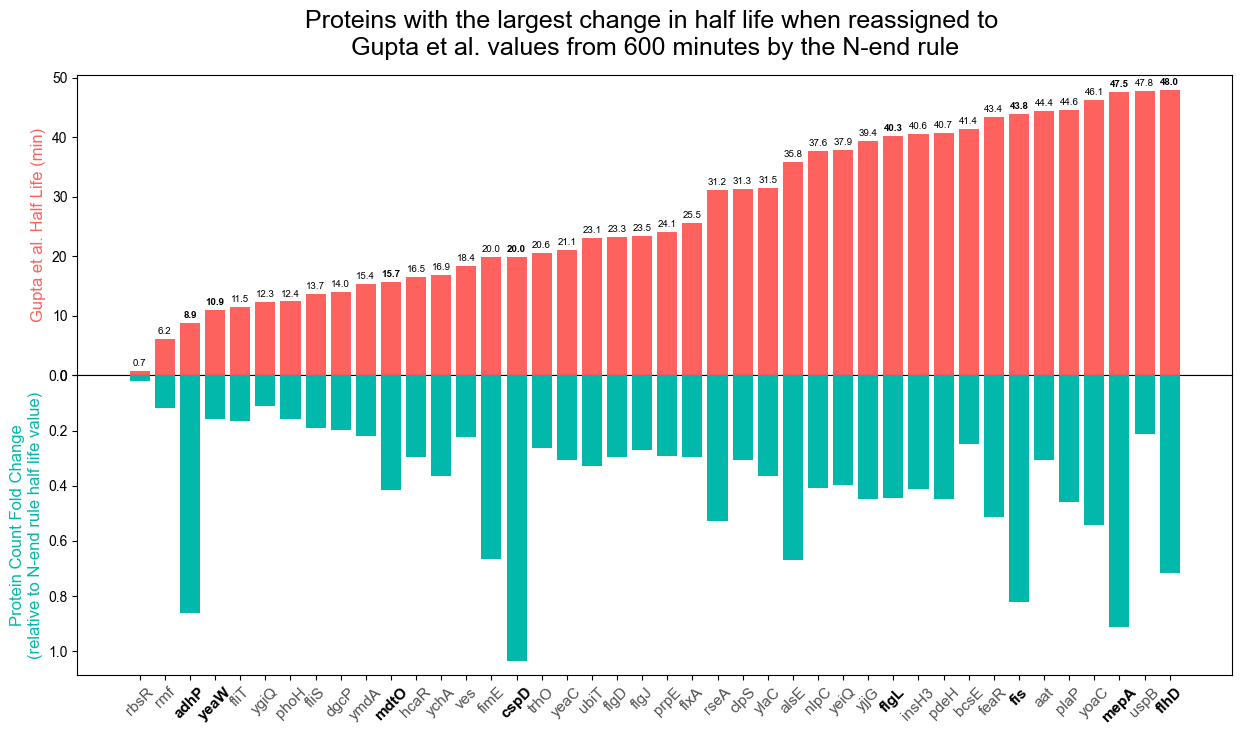

In [316]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional

# by just simply looking at the data in this table, I can see the following are in complexes: /Users/miagrahn/wcEcoli/out/complex_classification_tables/monomers_under_300_mins_sorted.csv
in_complexes = ['adhP', 'yeaW', 'mdtO', 'cspD', 'flgL', 'fis', 'mepA', 'flhD']

# phoH is the only one that is actively degraded here, so idk if its worth trying to make that special 


font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data['HL value']
column1 = data['protein_fold_change']
title0 = 'Proteins with the largest change in half life when reassigned to \nGupta et al. values from 600 minutes by the N-end rule'
title1 = 'N-end rule half life (600 mins) - Gupta et al. 2024 half life'

fig, axes = plt.subplots(figsize=(15,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
for i, val in enumerate(column0):
    if data.index[i] in in_complexes:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, fontweight='bold', color='black')
    else:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


axes[1].bar(index, column1, align='center', color=color_blue, zorder=10)
axes[1].tick_params(axis='x', labelsize=11)
    
axes[1].set(xticks=data.index, xticklabels=data.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
    if tick.get_text() in in_complexes:
        tick.set_fontweight('bold')
        tick.set_color('black')
    else:
        tick.set_fontweight('normal')
        tick.set_color(font_color)

axes[1].invert_yaxis()

axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes[1].set_ylabel('Protein Count Fold Change\n(relative to N-end rule half life value)', fontsize=12, color=color_blue, )

plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/CLClim3NE1_protein_counts_vs_CLNE_11192024_protein_counts/Clim3_related/Gupta_et_al_2024_largest_changes_in_half_life_with_PC_fold_change_highlighted.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

# blue is avg protein counts

In [317]:
# plot the largest changes against the half lives and have the common name above the bars and the color dependent on the protease assignment:
data1 = largest_change[['gene symbol','HL value', CLClimNE_new_name, CLNE_new_name]]
data1.set_index('gene symbol', inplace=True)

data1

,HL value,Log10 CLClim3NE1 Average Monomer Counts,Log10 CLNE_11192024 Average Monomer Counts
gene symbol,,,
rbsR,0.708811,0.053854,1.731011
rmf,6.165352,3.487947,4.419169
adhP,8.867585,2.597600,2.662772
yeaW,10.906607,0.170686,0.975811
fliT,11.469439,2.712679,3.490012
ygiQ,12.335229,1.173960,2.135373
phoH,12.410689,1.942295,2.742356
fliS,13.660143,2.778650,3.495836
dgcP,13.955536,1.675820,2.379748


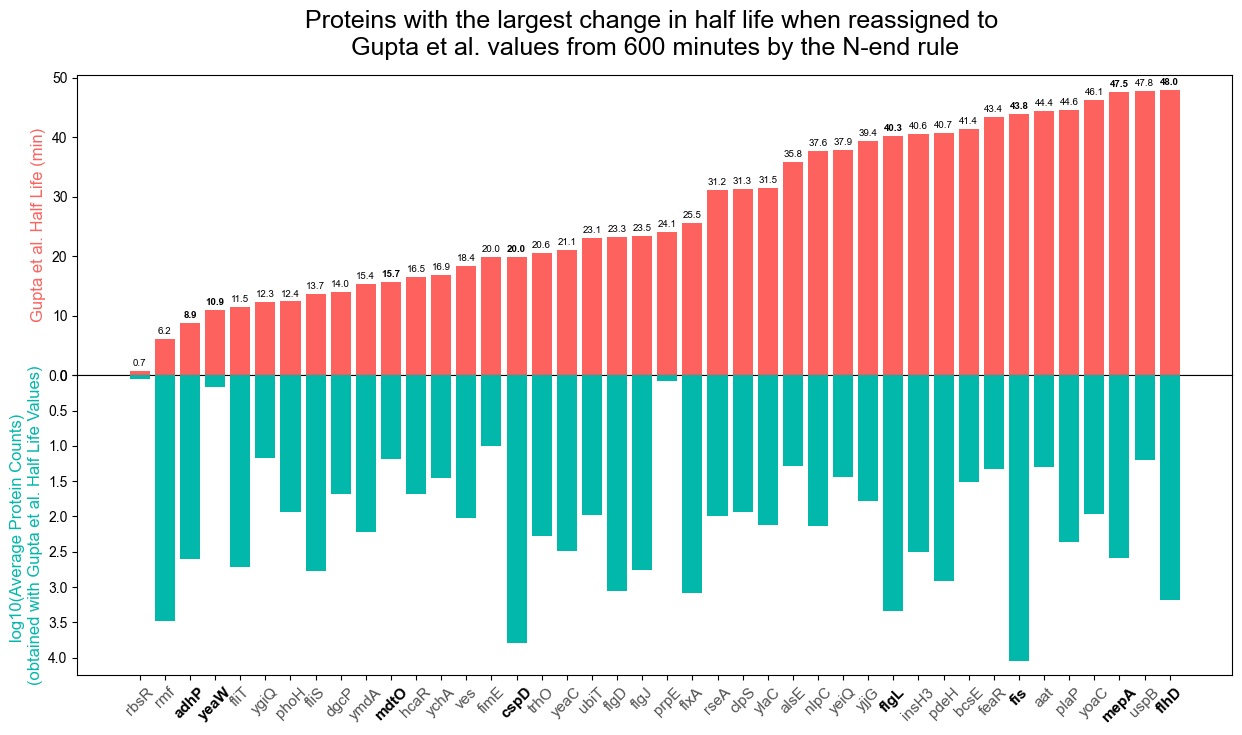

In [318]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional

# by just simply looking at the data in this table, I can see the following are in complexes: /Users/miagrahn/wcEcoli/out/complex_classification_tables/monomers_under_300_mins_sorted.csv
in_complexes = ['adhP', 'yeaW', 'mdtO', 'cspD', 'flgL', 'fis', 'mepA', 'flhD']

# phoH is the only one that is actively degraded here, so idk if its worth trying to make that special 


font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data1.index
column0 = data1['HL value']
column1 = data1[CLClimNE_new_name]
column2 = data1[CLNE_new_name]
title0 = 'Proteins with the largest change in half life when reassigned to \nGupta et al. values from 600 minutes by the N-end rule'


fig, axes = plt.subplots(figsize=(15,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
for i, val in enumerate(column0):
    if data1.index[i] in in_complexes:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, fontweight='bold', color='black')
    else:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


# make it a little fancy: 



axes[1].bar(index, column1, align='center', color=color_blue, zorder=10)
axes[1].tick_params(axis='x', labelsize=11)
axes[1].set(xticks=data1.index, xticklabels=data1.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
    if tick.get_text() in in_complexes:
        tick.set_fontweight('bold')
        tick.set_color('black')
    else:
        tick.set_fontweight('normal')
        tick.set_color(font_color)

axes[1].invert_yaxis()
axes[1].set_ylabel('log10(Average Protein Counts) \n(obtained with Gupta et al. Half Life Values)', fontsize=12, color=color_blue, )

plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/CLClim3NE1_protein_counts_vs_CLNE_11192024_protein_counts/Clim3_related/Gupta_et_al_2024_largest_changes_in_half_life_with_PCs_highlighted.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

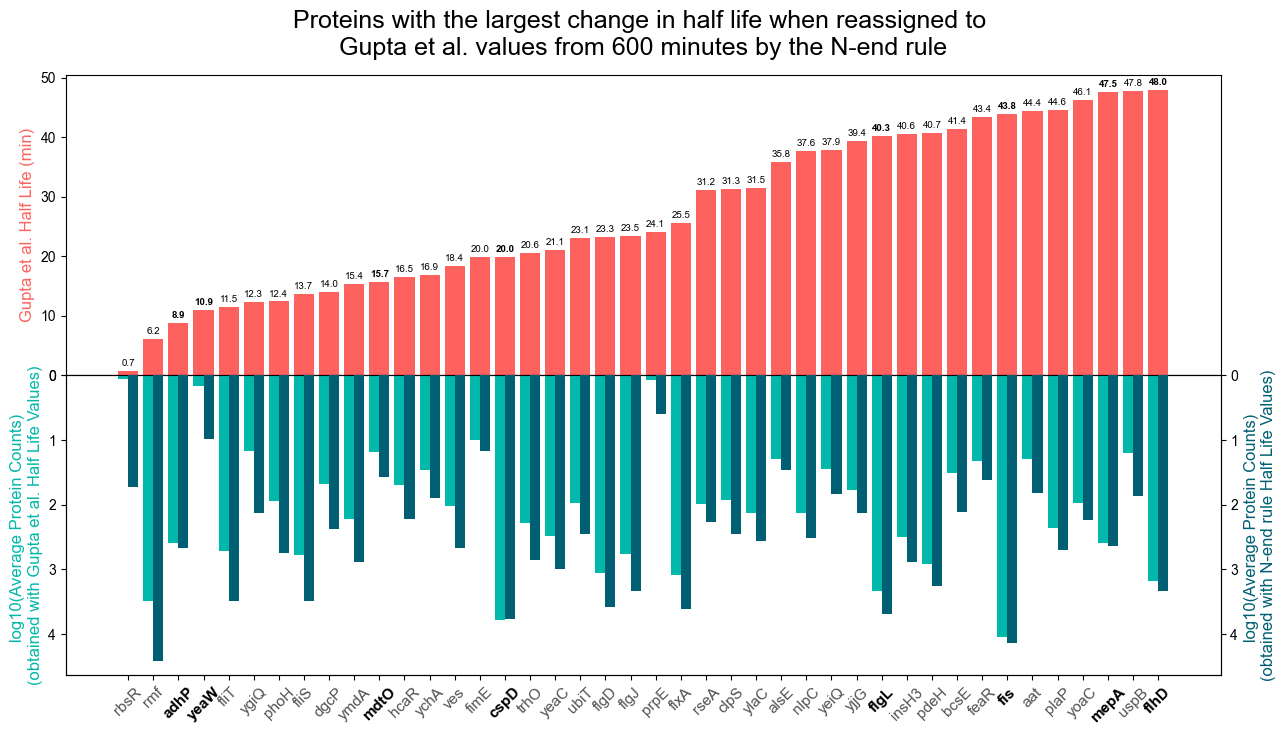

In [319]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional

# by just simply looking at the data in this table, I can see the following are in complexes: /Users/miagrahn/wcEcoli/out/complex_classification_tables/monomers_under_300_mins_sorted.csv
in_complexes = ['adhP', 'yeaW', 'mdtO', 'cspD', 'flgL', 'fis', 'mepA', 'flhD']

# phoH is the only one that is actively degraded here, so idk if its worth trying to make that special 


font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
color_dark_blue = '#005f73'
index = data1.index
column0 = data1['HL value']
column1 = data1[CLClimNE_new_name]
column2 = data1[CLNE_new_name]
title0 = 'Proteins with the largest change in half life when reassigned to \nGupta et al. values from 600 minutes by the N-end rule'


fig, axes = plt.subplots(figsize=(15,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
for i, val in enumerate(column0):
    if data1.index[i] in in_complexes:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, fontweight='bold', color='black')
    else:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


# make it a little fancy (based off this: https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped): 
N = len(data1.index)
ind = np.arange(N)  # the x locations for the groups
width = .4


axes[1].bar(ind-width/2, column1, width, align='center', color=color_blue, zorder=10)
axes[1].bar(ind+width/2, column2, width, align='center',color=color_dark_blue, zorder=10) # NOTE: this must be plotted. OTHERWISE, the y axis on the reverse side does NOT have the same scale as the left side

axes[1].tick_params(axis='x', labelsize=11)
axes[1].set(xticks=data1.index, xticklabels=data1.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
    if tick.get_text() in in_complexes:
        tick.set_fontweight('bold')
        tick.set_color('black')
    else:
        tick.set_fontweight('normal')
        tick.set_color(font_color)

axes[1].invert_yaxis()
axes[1].set_ylabel('log10(Average Protein Counts) \n(obtained with Gupta et al. Half Life Values)', fontsize=12, color=color_blue,)
axes2 = axes[1].twinx()
axes2.bar(ind+width/2, column2, width, align='center',color=color_dark_blue, zorder=10, ) # NOTE: This must be here in order to invert the second y axis counts
axes2.set_ylabel('log10(Average Protein Counts) \n(obtained with N-end rule Half Life Values)', fontsize=12, color=color_dark_blue,)
axes2.invert_yaxis()

plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/CLClim3NE1_protein_counts_vs_CLNE_11192024_protein_counts/Clim3_related/Gupta_et_al_2024_largest_changes_in_half_life_with_PCs_highlighted.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')